In [1]:
# Install required libraries
!pip install yfinance timesfm

  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 5.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7

In [1]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [4]:

# Download stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")



# Drop rows with NaN values (caused by rolling window calculations)
data = data.dropna()

df = data[['Close']].reset_index()
df.columns = ['date', 'close']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,close
date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-09,130.149994
...,...
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [17]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [18]:


# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [19]:
import timesfm


context_len=64
input_patch_len=32
horizon_len=1



model = timesfm.TimesFm(
    context_len=context_len,
    horizon_len=horizon_len,
    input_patch_len=input_patch_len,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.44 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.56 seconds.
Jitting decoding.
Jitted decoding in 18.76 seconds.


In [51]:
batch_sizes = range(1, 33, 3)  # لیستی از اندازه‌های مختلف batch size برای آزمایش
results_by_batch_size = []

for batch_size in batch_sizes:


    input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)

    # پردازش و محاسبه سود
    for i, example in enumerate(input_data()):
        raw_forecast, _ = model.forecast(
            inputs=example["inputs"], freq=[0] * len(example["inputs"])
        )

        for j in range(len(example["inputs"])):
            result = {
                'input_index': j,
                'train_start_date': str(example["dates"][j][0]),
                'train_end_date': str(example["dates"][j][-2]),
                'predict_date': str(example["dates"][j][-1]),
                'raw_forecast': raw_forecast[j][0],
                'y_actual': example["outputs"][j][0],
                'batch_size': batch_size,
                'context_len': context_len,
                'input_patch_len': input_patch_len
            }
            results_by_batch_size.append(result)



In [53]:
 results_df = pd.DataFrame(results_by_batch_size)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,0,2023-01-03 00:00:00,2023-04-04 00:00:00,2023-04-05 00:00:00,166.959579,163.759995,1,64,32
1,0,2023-01-04 00:00:00,2023-04-05 00:00:00,2023-04-06 00:00:00,165.057465,164.660004,1,64,32
2,0,2023-01-05 00:00:00,2023-04-06 00:00:00,2023-04-10 00:00:00,165.524918,162.029999,1,64,32
3,0,2023-01-06 00:00:00,2023-04-10 00:00:00,2023-04-11 00:00:00,162.622696,160.800003,1,64,32
4,0,2023-01-09 00:00:00,2023-04-11 00:00:00,2023-04-12 00:00:00,161.525681,160.100006,1,64,32
...,...,...,...,...,...,...,...,...,...
2030,25,2023-09-21 00:00:00,2023-12-20 00:00:00,2023-12-21 00:00:00,195.240768,194.679993,31,64,32
2031,26,2023-09-22 00:00:00,2023-12-21 00:00:00,2023-12-22 00:00:00,194.696442,193.600006,31,64,32
2032,27,2023-09-25 00:00:00,2023-12-22 00:00:00,2023-12-26 00:00:00,194.012909,193.050003,31,64,32
2033,28,2023-09-26 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,193.501068,193.149994,31,64,32


In [58]:
import matplotlib.pyplot as plt

# DataFrame برای نگه‌داری نتایج نهایی
final_results = []

# برای هر اندازه batch size محاسبات رو انجام می‌دهیم
for batch_size in batch_sizes:
    # فیلتر کردن داده‌ها برای batch size فعلی
    batch_results = [res for res in results_by_batch_size if res['batch_size'] == batch_size]

    # محاسبه MSE
    mse_value = mean_squared_error(
        [res['y_actual'] for res in batch_results],
        [res['raw_forecast'] for res in batch_results]
    )

    # محاسبه Accuracy
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(batch_results)):
        actual_today = batch_results[i]['y_actual']
        predicted_today = batch_results[i]['raw_forecast']
        actual_yesterday = batch_results[i - 1]['y_actual']
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1
    accuracy_value = correct_predictions / total_predictions if total_predictions > 0 else 0

    # محاسبه Profit
    initial_investment_model = 100
    capital_model = initial_investment_model
    shares_model = 0
    for i in range(1, len(batch_results)):
        if batch_results[i]['raw_forecast'] > batch_results[i - 1]['raw_forecast'] and capital_model > 0:
            shares_model = capital_model / batch_results[i]['y_actual']
            capital_model = 0
        elif batch_results[i]['raw_forecast'] < batch_results[i - 1]['raw_forecast'] and shares_model > 0:
            capital_model = shares_model * batch_results[i]['y_actual']
            shares_model = 0
    final_capital_model = capital_model + shares_model * batch_results[-1]['y_actual']
    profit_value = final_capital_model - initial_investment_model

    # ثبت نتایج برای هر batch size
    final_results.append({
        'batch_size': batch_size,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'profit': profit_value
    })




In [55]:
# تبدیل نتایج به DataFrame
final_results_df = pd.DataFrame(final_results)

# نمایش نتایج
print(final_results_df)



    batch_size       mse  accuracy     profit
0            1  5.479234  0.456522  12.098695
1            4  5.479234  0.456522  12.098695
2            7  5.479234  0.456522  12.098695
3           10  5.479234  0.456522  12.098695
4           13  5.479234  0.456522  12.098695
5           16  5.479234  0.456522  12.098695
6           19  5.479234  0.456522  12.098695
7           22  5.479234  0.456522  12.098695
8           25  5.479234  0.456522  12.098695
9           28  5.479234  0.456522  12.098695
10          31  5.479234  0.456522  12.098695


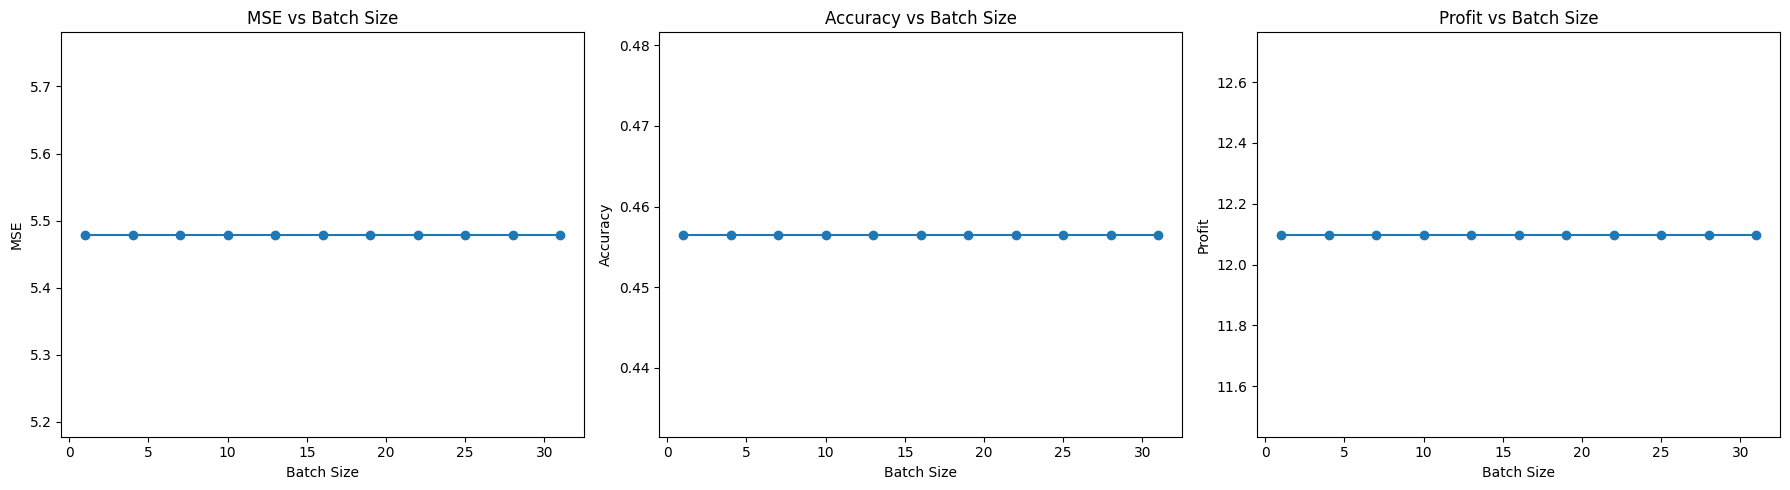

In [59]:

# رسم نمودار تغییرات MSE، Accuracy و Profit بر حسب batch size
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(final_results_df['batch_size'], final_results_df['mse'], marker='o')
plt.title('MSE vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('MSE')

plt.subplot(1, 3, 2)
plt.plot(final_results_df['batch_size'], final_results_df['accuracy'], marker='o')
plt.title('Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(final_results_df['batch_size'], final_results_df['profit'], marker='o')
plt.title('Profit vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Profit')

plt.tight_layout()
plt.show()